MNIST

In [1]:
import numpy as np
import torch
import torch.utils.data as tud
import torch.nn as tnn

In [2]:
import matplotlib.pyplot as plt

In [3]:
from copy import deepcopy as dcopy

In [4]:
import torchvision as tv
import torchvision.datasets as tvds

In [5]:
mnist_trainset = tvds.MNIST(root='./data', train=True, download=True, transform=tv.transforms.ToTensor())
mnist_testset = tvds.MNIST(root='./data', train=False, download=True, transform=tv.transforms.ToTensor())

In [6]:
train_set, val_set = tud.random_split(mnist_trainset, [50000,10000], generator=torch.Generator().manual_seed(0))

In [7]:
test_set=mnist_testset

In [8]:
del mnist_testset, mnist_trainset

In [9]:
# batch size increased for faster training
train_loader = tud.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
val_loader = tud.DataLoader(val_set, batch_size=10000, shuffle=True, drop_last=True)
test_loader = tud.DataLoader(test_set, batch_size=10000, shuffle=True, drop_last=True)

In [10]:
class my_nn_2(tnn.Module):
  def __init__(self, h=128, d_in=784, d_out=10):
    super(my_nn_2, self).__init__()
    self.linear1 = tnn.Linear(d_in, h)
    self.linear2 = tnn.Linear(h, d_out)
    # https://medium.com/@zhang_yang/understanding-cross-entropy-implementation-in-pytorch-softmax-log-softmax-nll-cross-entropy-416a2b200e34
    # softmax + nll loss is worse than cross entropy loss

  def forward(self, x):
    h_relu = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h_relu)
    return y_pred

In [11]:
crit_bce = tnn.CrossEntropyLoss()
crit_mse = tnn.MSELoss()

In [12]:
def fit(h=128, epochs=20, criterion=tnn.CrossEntropyLoss(), lr=1e-3):
  model = my_nn_2(h)
  opt = torch.optim.SGD(model.parameters(), lr=lr)
  tlh=[]
  tah=[]
  vlh=[]
  vah=[]
  vl_min=10**10
  for ep in range(epochs):
    model.train()
    training_loss=0
    acc=0
    for (idx, b) in enumerate(train_loader):
      xb=b[0].reshape(-1,784).float()
      yb=b[1]
      yb_pred = model(xb)
      loss=criterion(yb_pred, yb)
      training_loss+=loss
      acc+=torch.sum(torch.argmax(yb_pred, axis=1)==yb)
      opt.zero_grad()
      loss.backward()
      opt.step()
    tah.append(acc/50000)
    tlh.append(training_loss/50000)
    model.eval()
    with torch.no_grad():
      val_loss=0
      acc=0
      for (idx, b) in enumerate(val_loader):
        xb=b[0].reshape(-1,784).float()
        yb=b[1]
        yb_pred = model(xb)
        loss=criterion(yb_pred, yb)
        acc+=torch.sum(torch.argmax(yb_pred, axis=1)==yb)
        val_loss+=loss
      vah.append(acc/10000)
      vl=val_loss/64
      if vl<vl_min:
        best_model=dcopy(model)
        vl_min=vl
      vlh.append(vl)
  return best_model, tlh, tah, vlh, vah

In [13]:
model, tlh, tah, vlh, vah = fit()

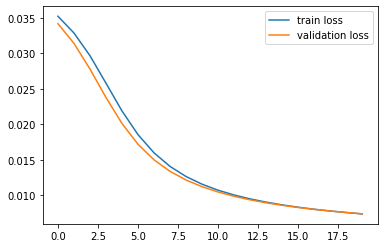

In [14]:
plt.plot(tlh, label="train loss")
plt.plot(vlh, label="validation loss")
plt.legend()
plt.show()

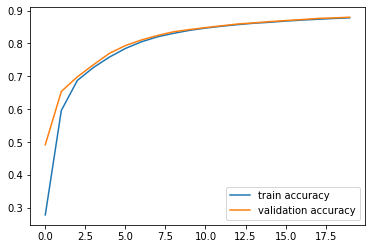

In [15]:
plt.plot(tah, label="train accuracy")
plt.plot(vah, label="validation accuracy")
plt.legend()
plt.show()

In [16]:
hl_sizes=[32,64,128,256,512]
best_vl=[]
for hl in hl_sizes:
  _, tlh, tah, vlh, vah = fit(h=hl, epochs=20, lr=1e-3)
  best_vl.append(np.min(vlh))

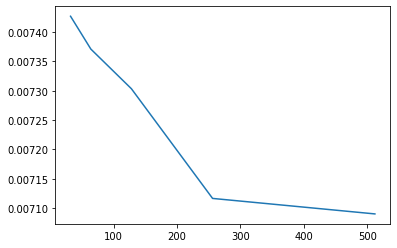

In [17]:
plt.plot(hl_sizes, best_vl)
plt.show()

In [18]:
# h=512 gives best results

In [19]:
lr_vals=[10**(i-5) for i in range(5)]
best_vl=[]
for lr in lr_vals:
  _, tlh, tah, vlh, vah = fit(epochs=20, lr=lr)
  best_vl.append(np.min(vlh))

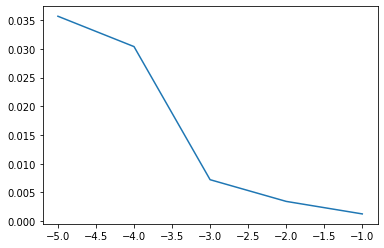

In [20]:
plt.plot(np.log10(lr_vals), best_vl)
plt.xlabel = "Learning rate as a power of 10"
plt.show()

In [21]:
# lr=0.1 gives best results

In [22]:
full_test_loader = tud.DataLoader(test_set, batch_size=1500)
for pts in full_test_loader:
  test_pts=pts

In [23]:
best_m, tlh, tah, vlh, vah = fit(h=512, epochs=20, criterion=crit_bce, lr=0.1)

In [24]:
# mean loss
label_pred = best_m(test_pts[0].reshape(-1,784).float())
crit_bce(label_pred, test_pts[1])/64

tensor(0.0010, grad_fn=<DivBackward0>)

In [25]:
label_pred=torch.argmax(label_pred, axis=1)

In [26]:
# accuracy
print(torch.sum(label_pred==test_pts[1])/(label_pred.shape[0]))

tensor(0.9810)


In [27]:
# very good test accuracy

In [31]:
class my_nn_3(tnn.Module):
  def __init__(self, h=128, d_in=784, d_out=10):
    super(my_nn_3, self).__init__()
    self.linear1 = tnn.Linear(d_in, h)
    self.dropout = tnn.Dropout(0.3)
    self.linear2 = tnn.Linear(h, d_out)

  def forward(self, x):
    h_relu = self.linear1(x).clamp(min=0)
    h_drop = self.dropout(h_relu)
    y_pred = self.linear2(h_drop)
    return y_pred

In [32]:
def fit_2(h=512, epochs=20, criterion=tnn.CrossEntropyLoss(), lr=1e-1):
  model = my_nn_3(h)
  opt = torch.optim.SGD(model.parameters(), lr=lr)
  tlh=[]
  tah=[]
  vlh=[]
  vah=[]
  vl_min=10**10
  for ep in range(epochs):
    model.train()
    training_loss=0
    acc=0
    for (idx, b) in enumerate(train_loader):
      xb=b[0].reshape(-1,784).float()
      yb=b[1]
      yb_pred = model(xb)
      loss=criterion(yb_pred, yb)
      training_loss+=loss
      acc+=torch.sum(torch.argmax(yb_pred, axis=1)==yb)
      opt.zero_grad()
      loss.backward()
      opt.step()
    tah.append(acc/50000)
    tlh.append(training_loss/50000)
    model.eval()
    with torch.no_grad():
      val_loss=0
      acc=0
      for (idx, b) in enumerate(val_loader):
        xb=b[0].reshape(-1,784).float()
        yb=b[1]
        yb_pred = model(xb)
        loss=criterion(yb_pred, yb)
        acc+=torch.sum(torch.argmax(yb_pred, axis=1)==yb)
        val_loss+=loss
      vah.append(acc/10000)
      vl=val_loss/64
      if vl<vl_min:
        best_model=dcopy(model)
        vl_min=vl
      vlh.append(vl)
  return best_model, tlh, tah, vlh, vah

In [33]:
best_m, _, _, _, _ = fit_2()

In [35]:
best_m

my_nn_3(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=512, out_features=10, bias=True)
)

In [37]:
label_pred = best_m(test_pts[0].reshape(-1,784).float())
print(crit_bce(label_pred, test_pts[1])/64)
label_pred=torch.argmax(label_pred, axis=1)
print(torch.sum(label_pred==test_pts[1])/(label_pred.shape[0]))

tensor(0.0009, grad_fn=<DivBackward0>)
tensor(0.9810)


In [ ]:
# very similar results